In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import collections  as mc
import math
import os
plt.rcParams['figure.figsize'] = (10, 10)

In [2]:
#Funciones Auxiliares
def sumaV(x,y):
    '''Suma 2 vectores dados'''
    a,b=x
    c,d=y
    return (a+c,b+d)
def multV(n,a):
    '''Multiplica un vector a por una constante n'''
    a1,a2 = a
    return (a1*n,a2*n)
def m2V(n,m,s):
    a,b=s
    return sumaV(multV(a,n),multV(b,m))
def rota(vect, theta):
    '''Rota un vector en un ángulo en Theta grados'''
    ang = float((theta/180.0)*math.pi)
    (x,y) = vect
    vr = ((math.cos(ang)*x)-(math.sin(ang)*y), (math.sin(ang)*x)+(math.cos(ang)*y))
    return vr
def getLim(u,v,m,n):
    (a1,a2) = multV(m,u)
    (b1,b2) = multV(n,v)
    (c1,c2) = m2V(u,v,(m,n))
    xma = max(a1,b1,c1,0)
    xmi = min(a1,b1,c1,0)
    yma = max(a2,b2,c2,0)
    ymi = min(a2,b2,c2,0)
    return [xmi-1, xma+1], [ymi-1, yma+1]
def dist(a, b):
    a1, a2 = a
    b1, b2 = b
    return math.sqrt(((b1-a1)**2)+((b2-a2)**2))
def cAng(u,v):
    (u1,u2),(v1,v2) = u, v
    return math.degrees(math.acos(((u1*v1)+(u2*v2))/(dist((0,0),u)*dist((0,0),v))))

In [3]:
class Atomo:
    '''Clase que define un atomo en el sistema'''
    def __init__(self, pos, color='black', sig='C', lvl=1):
        '''Inicializa el objeto Atomo usando como entradas su posición (x,y) pos y su color caracteristico color'''
        self.pos = pos
        self.color = color
        self.enlaces = []
        self.sig = sig
        self.lvl = lvl
    
    def __str__(self):
        return self.sig + str(self.pos)

    def printAtomo(self, r, axs):
        '''Imprime un Atomo en un Patch en el axs señalado'''
        axs.add_patch(plt.Circle((self.pos), r , color=self.color))

    def setEnlace(self, atm):
        '''Enlaza 2 Atomos'''
        self.enlaces.append(atm)
        atm.enlaces.append(self)
        return 1
    
    def clasifica(self, lols):
        if len(lols)==0:
            lols.append([self])
            return 1
        for l in lols:
            if len(l)==0:
                l.append(this)
                return 1
            else:
                if l[0].sig==self.sig:
                    l.append(self)
                    return 1
        lols.append([self])
        return 0


In [4]:
class Malla:
    def __init__(self, u, v, theta = 0.0, atms=[], enls=[], name='', prof=1):
        lols = []
        (u1,u2),(v1,v2) = u,v
        ang = abs(cAng(u,v))
        
        self.OriginalU = u
        self.OriginalV = v
        self.prof = prof
        self.theta = theta
        self.enls = enls
        self.inAngle = ang
        
        if theta==0.0:
            self.u = u
            self.v = v
        else:
            self.u = rota(u,theta)
            self.v = rota(v,theta)
        
        for a in atms:
            a.clasifica(lols)
        self.atms = lols
        
        if name=='':
            self.name = "Malla(inAngle={:.3f}°)".format(ang)
        else:
            self.name = name
    
    def __str__(self):
        return self.showData()
    
    def showNM(self, n, m, n0=0 ,m0=0, t=10,name=''):
        red=[]
        lx1,ly1 = getLim(self.u,self.v,n,m)
        mi,ma = min(lx1[0],ly1[0]), max(lx1[1],ly1[1])
        lx2,ly2 = getLim(self.u,self.v,n,m0)
        mi,ma = min(lx2[0],ly2[0],mi), max(lx2[1],ly2[1],ma)
        lx3,ly3 = getLim(self.u,self.v,n0,m)
        mi,ma = min(lx3[0],ly3[0],mi), max(lx3[1],ly3[1],ma)
        lx4,ly4 = getLim(self.u,self.v,n0,m0)
        mi,ma = (min(lx4[0],ly4[0],mi)-1), (max(lx4[1],ly4[1],ma)+1)
        ats=[]
        col=[]
        enls=[]
        self.enls=[]
        for i in range(abs(n-n0)):
            a=i+n0
            for j in range(abs(m-m0)):
                b=j+m0
                #Carga contornos de celda
                red.append([m2V(self.u,self.v,(a,b)),m2V(self.u,self.v,(a+1,b))])
                red.append([m2V(self.u,self.v,(a,b)),m2V(self.u,self.v,(a,b+1))])
                red.append([m2V(self.u,self.v,(a+1,b)),m2V(self.u,self.v,(a+1,b+1))])
                red.append([m2V(self.u,self.v,(a,b+1)),m2V(self.u,self.v,(a+1,b+1))])
                #Carga los atomos
                for c in self.atms:
                    for at in c:
                        (pu,pv) = at.pos
                        na = m2V(self.u,self.v,(a+pu,b+pv))
                        ats.append(na)
                        col.append(at.color)
                #Carga los enlaces
                for (ei,ef) in self.enls:
                    (ei1,ei2) = ei
                    (ef1,ef2) = ef
                    o = m2V(self.u,self.v,(a+ei1,b+ei2))
                    f = m2V(self.u,self.v,(a+ef1,b+ef2))
                    enls.append([o,f])
        fig, maxs = plt.subplots()
        lis = np.array(ats)
        xs, ys = lis[:,0], lis[:,1]
        #Dibuja los Atomos
        maxs.scatter(xs,ys, color=col,s=t)
        lc = mc.LineCollection(np.array(enls), colors='black', linewidths=(t/10))
        lr = mc.LineCollection(np.array(red), colors='gray', linewidths=(t/15))
        #Dibuja los Enlaces
        maxs.add_collection(lc)
        #Dibuja los contornos de las celdas
        maxs.add_collection(lr)
        maxs.axes.xaxis.set_visible(False)
        maxs.axes.yaxis.set_visible(False)
        maxs.set(xlim=(mi,ma), ylim = (mi,ma))
        if name!='':
            plt.savefig(name,dpi=900, bbox_inches='tight')
        plt.show()
        return 1
    
    def addAtms(self, lols):
        for l in lols:
            for a in l:
                a.clasifica(self.atms)
        return 1
        
    def showData(self):
        ang = cAng((1,0),self.u)
        (u1,u2) = rota(self.u,-ang)
        (v1,v2) = rota(self.v,-ang)
        data=self.name+'''
1.0
        {:.10f}         {:.10f}         0.0000000000
        {:.10f}         {:.10f}         0.0000000000
        0.0000000000         0.0000000000         {:.10f}
'''.format(u1,u2,v1,v2,(self.prof*5))
        atms1=""
        atms2=""
        atms3="Direct"
        for i in range(len(self.atms)):
            atms1=atms1+"\t{}".format(self.atms[i][0].sig)
            atms2=atms2+"\t{}".format(len(self.atms[i]))
            for a in self.atms[i]:
                (x,y)=a.pos
                atms3=atms3+"\n     {:.10f}         {:.10f}         {:.10f}".format(abs(x),abs(y),((a.lvl-1)/self.prof))
        atms = atms1+"\n"+atms2+"\n"+atms3
        data = data+atms
        return data
    
    def mRot(self, ang):
        nu, nv = self.OriginalU, self.OriginalV
        ntheta = (self.theta + ang)
        natms, nenls = self.atms, self.enls
        nName = self.name+"\'"
        mr=Malla(nu, nv, theta=ntheta, enls=nenls, name=nName, prof=self.prof)
        mr.atms=self.atms
        return mr
    
    def exporta(self,name=''):
        if name=='':
            name=self.name
        name=name+".vasp"
        f = open(name,"w")
        f.write(self.showData())
        f.close()
        return 1
    
    def hortogonizar(self):
        if abs(self.inAngle-90)<0.0001:
            return self
        return self.transforma(1,1,0,2)
    
    def transforma(self, m, n, p, q):
        nu, nv = transfVs(self.u,self.v,(m, n, p, q))
        #nu, nv = m2V(self.u,self.v,(m,p)), m2V(self.u,self.v,(n,q))
        res = superMesh(nu,nv,[self])
        natms = []
        for atms in res.atms:
            natms.append(limpia(atms))
        res.atms=natms
        return res

In [5]:
def isitin(m,cent, sm, slvl):
    er = 1/(10**7)
    inUnit = False
    (u1,u2) = m.u
    (v1,v2) = m.v
    (p1,p2) = sm.u
    (q1,q2) = sm.v
    eq0 = (p2*q1)-(p1*q2)
    eq1 = (q1*u2)-(q2*u1)
    eq2 = (q1*v2)-(q2*v1)
    eq3 = (p2*u1)-(p1*u2)
    eq4 = (p2*v1)-(p1*v2)
    for c in m.atms:
        nc=[]
        for a in c:
            (x,y) = sumaV(cent,a.pos)
            nx = (eq1*x+eq2*y)/eq0
            ny = (eq3*x+eq4*y)/eq0
            if (nx<(1+er) and nx>(0-er)) and (ny<(1+er) and ny>(0-er)):
                nAtm = Atomo((nx,ny),color=a.color,sig=a.sig, lvl=(a.lvl+slvl))
                nAtm.clasifica(sm.atms)
    for e in m.enls:
        (x1,y1) = sumaV(cent,e[0])
        (x2,y2) = sumaV(cent,e[1])
        (ox,oy) = ((eq1*x1+eq2*y1)/eq0,(eq3*x1+eq4*y1)/eq0)
        f = ((eq1*x2+eq2*y2)/eq0,(eq3*x2+eq4*y2)/eq0)
        if (ox<1 and ox>0) and (oy<1 and oy>0):
            sm.enls.append([(ox,oy),f])
    return 1

def megeCut(mo, sm, lvl=0):
    (u1,u2), (v1,v2) = mo.u, mo.v
    (p1,p2), (q1,q2) = sm.u, sm.v
    np1 = ((p2*v1)-(p1*v2))/((u2*v1)-(u1*v2))
    np2 = ((p1*u2)-(p2*u1))/((u2*v1)-(u1*v2))
    nq1 = ((q2*v1)-(q1*v2))/((u2*v1)-(u1*v2))
    nq2 = ((q1*u2)-(q2*u1))/((u2*v1)-(u1*v2))
    npq1 = np1+nq1
    npq2 = np2+nq2
    lu = [round(min(np1,nq1,npq1,0)-1),round(max(np1,nq1,npq1,0)+1)]
    lv = [round(min(np2,nq2,npq2,0)-1),round(max(np2,nq2,npq2,0)+1)]
    for i in range(lu[1]-lu[0]):
        a = i+lu[0]
        for j in range(lv[1]-lv[0]):
            b = j+lv[0]
            isitin(mo,(a,b),sm,lvl)
    return 1

def superMesh(su,sv,loMs):
    sM = Malla(su,sv)
    sM.prof=0
    i=0
    for m in loMs:
        megeCut(m, sM, lvl=i)
        sM.prof=sM.prof+m.prof
        i = (i+1)*m.prof
    return sM

def hexa6(p,atms=['C','C'],name=''):
    u,v=(p,0.0),(-p/2,math.sqrt(3)*(p/2))
    p1,p2,p3,p4 = (1/3,2/3),(2/3,1/3),(1/3,-1/3),(4/3,2/3)
    ats = [Atomo(p1, sig = atms[0]),Atomo(p2, sig = atms[1])]
    return Malla(u,v,atms=ats,name=name,enls=[(p1,p2),(p2,p3),(p2,p4)])

def hexa3(p,atms=['C','C'],name=''):
    u,v=(p,0.0),(-p/2,math.sqrt(3)*(p/2))
    p1,p2,p3,p4 = (0.0,0.0),(1/3,2/3),(0,1),(1,1)
    ats = [Atomo(p1, sig = atms[0]),Atomo(p2, sig = atms[1])]
    return Malla(u,v,atms=ats,name=name,enls=[(p1,p2),(p2,p3),(p2,p4)])

def rectMesh(p1,p2,atms='C',name=''):
    u,v = (p1,0.0),(p2,0.0)
    p1,p2,p3 = (1/2,1/2),(3/2,1/2),(1/2,3/2)
    atms = [Atomo(p1,sig = atms)]
    return Malla(u,v,atms=ats,name=name,enls=[(p1,p2),(p1,p3)])

def limpia(loa):
    err=1/(10**8)
    res = []
    for i in range(len(loa)):
        pasa=True
        x1,x2 = loa[i].pos
        if abs(x1-1) < err:
            for j in range(len(loa)):
                y1,y2=loa[j].pos
                if (abs(y1) < err) and (abs(x2-y2) < err):
                    pasa = pasa and False
            if pasa:
                res.append(loa[i])
        elif abs(x2-1) < err:
            pasa=True
            for j in range(i+1,len(loa)):
                y1,y2=loa[j].pos
                if abs(x1-y1) < err:
                    pasa = pasa and False
        if pasa:
            res.append(loa[i])
    return res

def transfVs(u,v,t):
    m,n,p,q = t
    return m2V(u,v,(m,p)), m2V(u,v,(n,q))

In [6]:
u,v=(2.44,0.0),(-1.22,math.sqrt(3)*1.22)
p1=(1/3,2/3)
p2=(2/3,1/3)
p3=(1/3,-1/3)
p4=(4/3,2/3)
a1=Atomo(p1, sig = 'C')
a2=Atomo(p2, sig = 'Si',color='Yellow')
ats = [a1,a2]
malla=Malla(u,v,atms=ats,name='cosa',enls=[(p1,p2),(p2,p3),(p2,p4)])
malla2=Malla(u,v,theta=21.78,atms=ats,name='cosa',enls=[(p1,p2),(p2,p3),(p2,p4)])

In [7]:
su = m2V(u,v,(2,-1))
sv = m2V(u,v,(1,3))
smalla = superMesh(su,sv,[malla,malla2])

In [ ]:
ssu = m2V(su,sv,(2,-1))
ssv = m2V(su,sv,(1,3))
smalla2 = malla.mRot(-21.78)
smalla.enls=[]
smalla2.enls=[]

smalla = superMesh(ssu,ssv,[smalla,smalla2])
smalla.exporta(name='3capas2')

In [ ]:
smalla.exporta(name='2capas')

In [ ]:
smalla.showNM(3,3)

In [ ]:
smalla.enls=[]
smalla2 = smalla.hortogonizar()
smalla2.enls=[]
smalla2.showNM(1,1)
smalla2.exporta(name='2CapasRec')

In [ ]:
#print(smalla2)

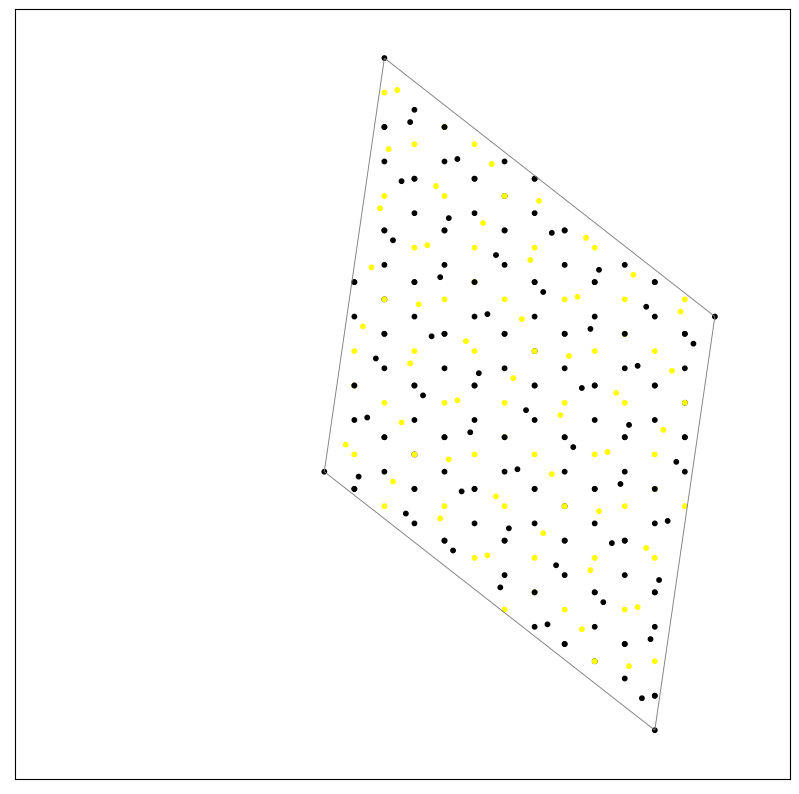

1

In [10]:
ssu = m2V(su,sv,(2,-1))
ssv = m2V(su,sv,(1,3))
smalla.enls=[]
hm.enls=[]
#smalla2.enls=[]
ssmalla = superMesh(ssu,ssv,[smalla,hm])
ssmalla.exporta(name='3capas')
ssmalla.showNM(1,1)

In [ ]:
print(smalla)

In [ ]:
print(ssmalla)

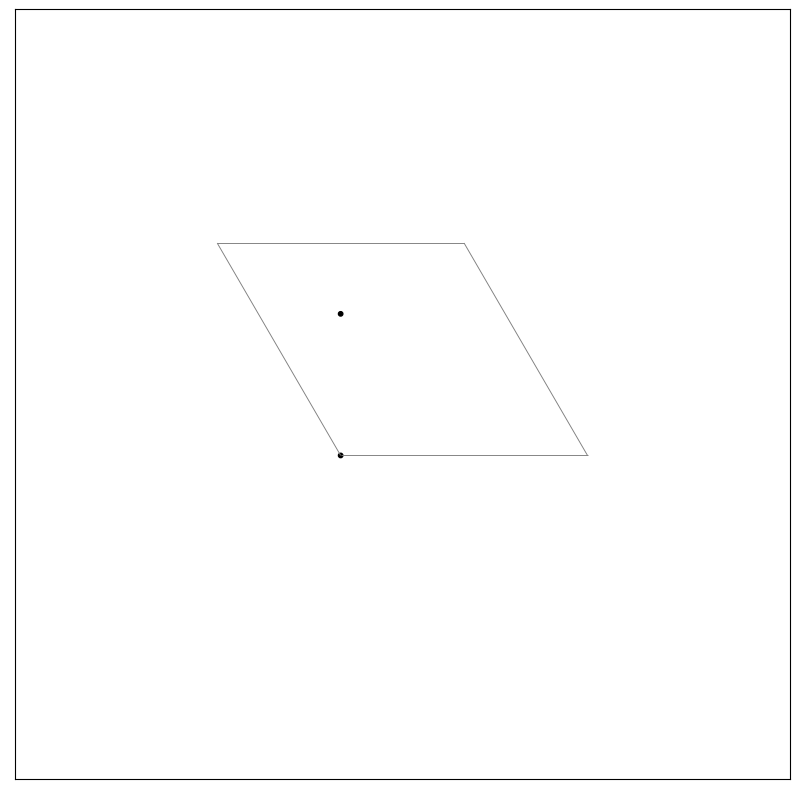

1

In [8]:
hm=hexa3(2.44,atms=['C','Si'],name='hexa')
hm.showNM(1,1)
len(hm.enls)
hm.exporta('CSi')

In [ ]:
smX=superMesh(su,sv,[malla,hm])
#smX.showNM(1,1)
smX.exporta('Cruzado')
print(smX)
mallaR=malla.mRot(21.78)
mallaR.exporta('Rotado')
ssu,ssv=transfVs(su,sv,(2,1,-1,3))
print(mallaR)

In [ ]:
'''smX3=superMesh(ssu,ssv,[smX,mallaR])
smX3.exporta('Cruzado3')
print(smX3)'''

smX.u

In [ ]:
print(rm)

In [ ]:
ssmalla.enls=[]
ssmalla.showNM(1,1)

In [11]:
def buscaTh(vectU,vectV, a, b, step=2, eps=0.01, show=True):
    res = []
    rmin = None
    epsm = eps
    factor = 10**step
    (u1,u2) = vectU
    (v1,v2) = vectV
    ax1 = (u2*v1)-(u1*v2)
    ax2 = (u1*v1)+(u2*v2)
    ax3 = (v1**2)+(v2**2)
    ax4 = (u1**2)+(u2**2)
    for i in range(180*factor):
        th = float((i/factor)-60)
        ang = math.radians(th)
        cos = math.cos(ang)
        sen = math.sin(ang)
        ru, rv = rota(vectU,th), rota(vectV,th)
        if(th%60!=0):
            if (a!=0)and(b!=0):
                c = (a*(ax1*cos-ax2*sen)/ax1)-(b*(ax3*sen)/ax1)
                d = (b*(ax1*cos+ax2*sen)/ax1)+(a*(ax4*sen)/ax1)
                r1 = sumaV(multV(a,vectU),multV(b,vectV))
                r2 = sumaV(multV(round(c),ru),multV(round(d),rv))
                err = dist(r1,r2)
                if err<eps:
                    res.append([a,b,round(c),round(d),round(th,step),err])
                    if err<epsm:
                        print("nuevo mejor=",th)
                        epsm = err
                        rmin = [a,b,round(c),round(d),round(th,step),err]
                    if show:
                        print("(a,b)=",(a,b)," (c,d)=",(round(c),round(d)),"Theta=",round(th,step),"err:",err)
    return res, rmin


In [13]:
res, rm=buscaTh(u,v,4,5)
rm

nuevo mejor= -59.99
(a,b)= (4, 5)  (c,d)= (-1, 4) Theta= -59.99 err: 0.0019515372295349357
(a,b)= (4, 5)  (c,d)= (-1, 4) Theta= -59.98 err: 0.00390307444420918
(a,b)= (4, 5)  (c,d)= (-1, 4) Theta= -59.97 err: 0.005854611629158477
(a,b)= (4, 5)  (c,d)= (-1, 4) Theta= -59.96 err: 0.007806148769521865
(a,b)= (4, 5)  (c,d)= (-1, 4) Theta= -59.95 err: 0.009757685850437665
(a,b)= (4, 5)  (c,d)= (1, 5) Theta= -38.26 err: 0.009131105508041578
(a,b)= (4, 5)  (c,d)= (1, 5) Theta= -38.25 err: 0.007179568406416302
(a,b)= (4, 5)  (c,d)= (1, 5) Theta= -38.24 err: 0.005228031250117356
(a,b)= (4, 5)  (c,d)= (1, 5) Theta= -38.23 err: 0.003276494054003424
nuevo mejor= -38.22
(a,b)= (4, 5)  (c,d)= (1, 5) Theta= -38.22 err: 0.0013249568329399724
nuevo mejor= -38.21
(a,b)= (4, 5)  (c,d)= (1, 5) Theta= -38.21 err: 0.000626580398214908
(a,b)= (4, 5)  (c,d)= (1, 5) Theta= -38.2 err: 0.0025781176245966027
(a,b)= (4, 5)  (c,d)= (1, 5) Theta= -38.19 err: 0.004529654831347055
(a,b)= (4, 5)  (c,d)= (1, 5) Theta= -

[4, 5, 4, -1, 81.79, 0.0006265803982118089]

In [18]:
def buscaMN(vectU,vectV, th, rang=15, eps=0.01, show=True):
    epsm = eps
    f1, f2 = 0, 0
    res = []
    rmin = [0,0,0,0,0.0,0.0,(0.0,0.0)]
    rmin2 = [0,0,0,0,0.0,0.0,(0.0,0.0)]
    ang = math.radians(th)
    cos = math.cos(ang)
    sen = math.sin(ang)
    ru, rv = rota(vectU,th), rota(vectV,th)
    (u1,u2) = vectU
    (v1,v2) = vectV
    ax1 = (u2*v1)-(u1*v2)
    ax2 = (u1*v1)+(u2*v2)
    ax3 = (v1**2)+(v2**2)
    ax4 = (u1**2)+(u2**2)
    print("Busqueda en a pos")
    for a in range(rang):
        for bp in range(rang):
            b=-bp
            if (a!=0)and(b!=0):
                c = (a*(ax1*cos-ax2*sen)/ax1)-(b*(ax3*sen)/ax1)
                d = (b*(ax1*cos+ax2*sen)/ax1)+(a*(ax4*sen)/ax1)
                r1 = sumaV(multV(a,vectU),multV(b,vectV))
                r2 = sumaV(multV(round(c),ru),multV(round(d),rv))
                err = dist(r1,r2)
                if err<eps:
                    if (round(c)!=0)and(round(d)!=0):
                        (f1,f2) = (c/round(c)),(d/round(d))
                    res.append([a,bp,round(c),round(d),th,err,(f1,f2)])
                    if err<epsm:
                        print("nuevo mejor=",(a,bp),(c,d))
                        epsm = err
                        rmin = [a,bp,round(c),round(d),th,err,(f1,f2)]
                    if show:
                        print("(m,n)=",(a,bp)," (c,d)=",(round(c),round(d)),"Theta=",th,"err:",err)
    print("Busqueda en a neg")
    epsm = eps
    for i in range(rang):
        a = i*(-1)
        for b in range(rang):
            if (a!=0)and(b!=0):
                c = (a*(ax1*cos-ax2*sen)/ax1)-(b*(ax3*sen)/ax1)
                d = (b*(ax1*cos+ax2*sen)/ax1)+(a*(ax4*sen)/ax1)
                r1 = sumaV(multV(a,vectU),multV(b,vectV))
                r2 = sumaV(multV(round(c),ru),multV(round(d),rv))
                err = dist(r1,r2)
                if err<eps:
                    if (round(c)!=0)and(round(d)!=0):
                        (f1,f2) = (c/round(c)),(d/round(d))
                    res.append([a,b,round(c),round(d),th,err,(f1,f2)])
                    if err<epsm:
                        print("nuevo mejor=",(a,bp),(c,d))
                        epsm = err
                        rmin2 = [a,bp,round(c),round(d),th,err,(f1,f2)]
                    if show:
                        print("(m,n)=",(a,bp)," (c,d)=",(round(c),round(d)),"Theta=",th,"err:",err)
    return res, rmin, rmin2

In [20]:
res, rm1, rm2=buscaMN(u,v,21.78*2)
rm1

Busqueda en a pos
nuevo mejor= (3, 5) (-2.9982211655102695, -7.999726121457195)
(m,n)= (3, 5)  (c,d)= (-3, -8) Theta= 43.56 err: 0.004047809979228034
(m,n)= (6, 10)  (c,d)= (-6, -16) Theta= 43.56 err: 0.008095619958456068
(m,n)= (11, 2)  (c,d)= (2, -11) Theta= 43.56 err: 0.007011012543407344
Busqueda en a neg
nuevo mejor= (-3, 14) (2.9982211655102695, 7.999726121457195)
(m,n)= (-3, 14)  (c,d)= (3, 8) Theta= 43.56 err: 0.004047809979228034
(m,n)= (-6, 14)  (c,d)= (6, 16) Theta= 43.56 err: 0.008095619958456068
(m,n)= (-11, 14)  (c,d)= (-2, 11) Theta= 43.56 err: 0.007011012543407344


[3,
 5,
 -3,
 -8,
 43.56,
 0.004047809979228034,
 (0.9994070551700899, 0.9999657651821494)]